### 전처리

> Data
- Input: FMguide에서 다운받은 excel 파일
- Output: csv file (아웃라이어 찾기, Stationary 적용 전 파일)

> Process
1. Excel 데이터 불러오고 기본 데이터프레임 형식으로 전처리
2. rf(risk free rate) 데이터(yfinance) 불러오기 및 데이터 병합
3. ROE 계산
4. COE 계산
5. GM 계산
6. 일반수익률 계산(n일 후 종목 종가 - 종목 종가 / 종목 종가)
7. 상대수익률 계산(종목 수익률 - 시장 수익률)
8. 데이터 내보내기

> 코드 구현 날짜
- 2023-11-01

> 개발환경
- Python version: 3.8.18

> 수정내용
- 수정날짜: 2023-11-08  
- 수정내용:
1. 전처리 코드 함수화
2. 새로 다운받은 20년치 데이터 중 최근 10년 데이터 전처리 및 각종 지표 계산

- 수정날짜: 2023-11-13
- 수정내용:  
1. ROE 계산법 변경
- 기존: 연도별 평균 ROE 계산  
예) 2020년 2분기 ROE = 2020년 1,2,3,4분기의 평균 계산  
2023년 2분기 경우에는 2023년 1,2분기의 평균값을 계산하였음.

- 변경후: 이동평균 ROE 계산(중첩하며 평균 ROE 계산)  
예) 2020년 2분기 ROE = 2019년 3,4분기와 2020년 1,2분기의 평균 계산

- 수정날짜: 2023-11-19
- 수정내용:
1. 변경된 ROE 계산법을 통해 ROE 계산에 필요한 모든 컬럼에 다 계단식 평균 구하기 적용

- 수정날짜: 2023-11-22
1. 우리 데이터  Dart 데이터와 비교 -> 동일
- 영업이익, 금융손익, EMS를 계단평균 적용
- COE 2년이동평균 계산(MA)
- 결과: 구한gm이 sustainable하지만 교수님이 기대하신 (1~2) 값 보다는 크게 나옴.
- 내일 모이는 분들 확인해보시고 아웃라이어로 판단되는 부분 제거, 시그마, 표준화 등 사용하여 gm 보고 가능하면 R^2 확인까지 해보면 좋을 것 같아요!

- 수정날짜 2023-11-23
- 수정내용:
현재 gm의 값을 분기별로 나누어 표준화 시켰습니다. 그 결과 gm의 값은 안정적으로 바뀌었고, 수익률과의 상관관계가 -0.35정도로 유의미한 결과를 얻을 수 있습니다. 현재 g.m과 수익률과의 관계를 어떻게 설명할지 논의하다, 오늘 마무리 지었습니다. 현재까지 생각한 방법으로는 g.m의 값이 어느 정도 기간 동안 상승이 유지되었을을 때, 가장 높은 수익률을 얻는지 찾는 방향으로 논의되었습니다. 구체적인 방법에 대해서는 계속 고민하며 공유하겠습니다 

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import os

# 한글과 음수 부호가 제대로 표시되는 폰트로 변경
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 표시 문제 해결

In [2]:
# 변수 정의

# 회사 리스트
company_list = ['SK텔레콤', 'KT', 'LG유플러스', '농심', 'CJ제일제당', '오뚜기', '현대차', '한국타이어', 'KB금융', '신한지주']
company = company_list[2] # 회사 선택

# 기간 설정 -> 10년치 데이터만 가져옴
start_dt = '2012-07-01'
end_dt = '2023-06-30'

# 엑셀 파일 경로
filename = '../FMguide_data/gm_model_20years.xlsx'

### FMguide 데이터 가져오기

In [3]:
# 전처리 함수
def load_data_guide(filename, sheet_name):
    raw_df = pd.read_excel(filename, sheet_name=sheet_name)
    col = raw_df[11:12] # 컬럼명 가져오기
    data = raw_df[13:] # 데이터 가져오기
    df = pd.concat([col, data]) # 컬럼명, 데이터 병합
    df.columns = df.iloc[0] # 컬럼 지정
    df.drop(df.index[0], inplace=True) # 필요없는 첫 행 삭제
    df.rename(columns={df.columns[0]:'Date'}, inplace=True) # 첫번째 컬럼의 컬럼명 변경
    df['Date'] = pd.to_datetime(df['Date']) # 시간형태로 변환
    df = df[(df['Date'] >= start_dt) & (df['Date'] <= end_dt)] # 원하는 기간 설정
    return df

In [4]:
# 함수를 사용해서 파일 읽기
df = load_data_guide(filename, company)
print("회사명: ", company)
df.head()

회사명:  LG유플러스


11,Date,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),종가(원),총자본(천원),PBR(배)
2491,2012-07-02,-10336000,-56562000,173000,5510,3730074000,0.5607
2492,2012-07-03,-10336000,-56562000,173000,5570,3730074000,0.56681
2493,2012-07-04,-10336000,-56562000,173000,5530,3730074000,0.56274
2494,2012-07-05,-10336000,-56562000,173000,5530,3730074000,0.56274
2495,2012-07-06,-10336000,-56562000,173000,5470,3730074000,0.55663


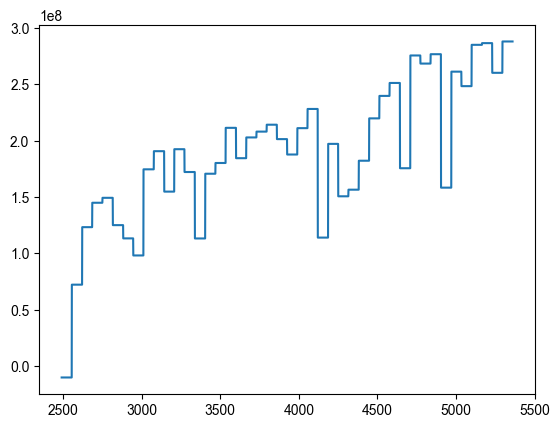

In [5]:
plt.plot(df['영업이익(천원)'])

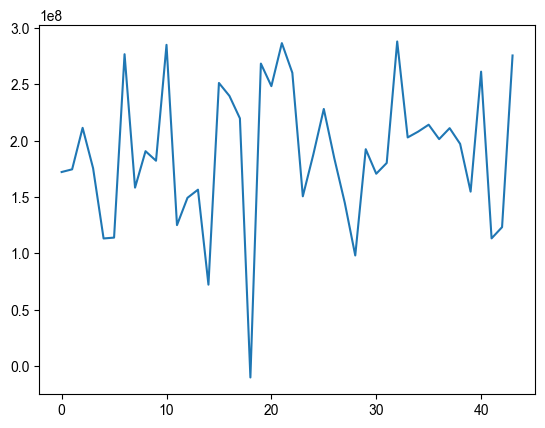

In [6]:
plt.plot(df['영업이익(천원)'].value_counts().index)

### COE 계산을 위한 rf 데이터 불러오기

- rf: risk free(미국채 10년물)

In [7]:
# 미국 국채 10년물 불러오는 함수
def load_us_10_year_data(start_date, end_date):
    us_10_year = yf.download("^TNX", start=start_date, end=end_date)
    us_10_year.rename(columns={'Close': 'us_10_treasury'}, inplace=True) # 컬럼명 변경
    us_10_year = us_10_year.reset_index() # Date(인덱스) -> 컬럼으로
    us_10_year = us_10_year[['Date', 'us_10_treasury']] # Date와 미국채 10년물만 가져오기
    return us_10_year

In [8]:
# 데이터 병합
us_10_year = load_us_10_year_data(start_dt, end_dt)
df = pd.merge(df, us_10_year, on='Date', how='outer') # 기존 df와 us_10_year데이터를 Date컬럼 기준으로 merge
df['us_10_treasury'] = df['us_10_treasury'].fillna(method='ffill') # us_10_treasury의 na 값을 ffill로(전날)데이터로 채워줌
#df = df.dropna() # NA인 행 삭제. NA라는 것은 영업일이 아니라는 의미이기 때문(공휴일인듯?)

[*********************100%%**********************]  1 of 1 completed


In [9]:
df['us_10_treasury_MA1Y'] = df['us_10_treasury'].rolling(window=240).mean()
df['us_10_treasury_MA2Y'] = df['us_10_treasury'].rolling(window=480).mean()

Text(0.5, 1.0, '미국채 10년물 원본')

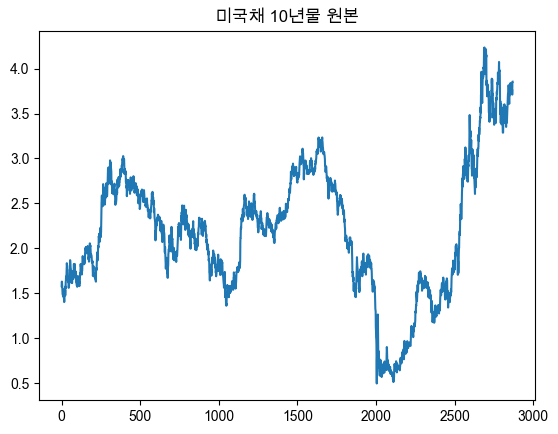

In [10]:
plt.plot(df['us_10_treasury'] )
plt.title('미국채 10년물 원본')

Text(0.5, 1.0, '미국채 10년물 2년 이동평균')

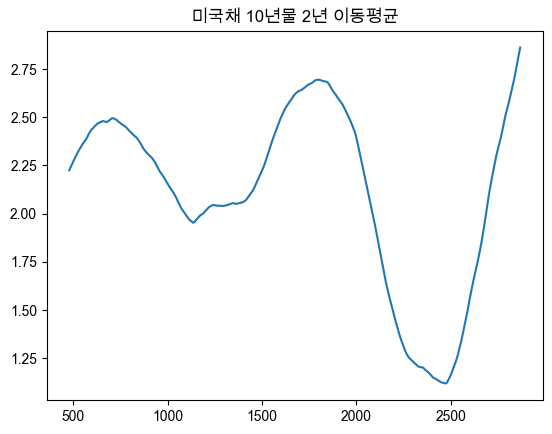

In [11]:
plt.plot(df['us_10_treasury_MA2Y'] )
plt.title('미국채 10년물 2년 이동평균')

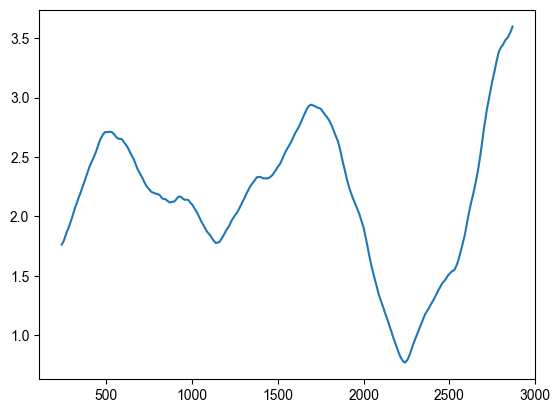

In [12]:
plt.plot(df['us_10_treasury_MA1Y'] )

### Equity(총자본(천원)) 계산

In [13]:
# 분기 나누는 함수
def get_quarter(date):
    year = date.year
    month = date.month

    if 2003 <= year <= 2023:
        if 1 <= month <= 3:
            return f'{year}Q1'
        elif 4 <= month <= 6:
            return f'{year}Q2'
        elif 7 <= month <= 9:
            return f'{year}Q3'
        elif 10 <= month <= 12:
            return f'{year}Q4'
    else:
        return None

In [14]:
df['Quarter'] = df['Date'].apply(get_quarter)

### COE 계산

COE = rf + Beta(MRP)

- Beta: 1
- MRP: 4%
- rf: 미국 국채 10년물

In [15]:
# beta랑 MRP 값
beta = 1
MRP = 4

In [16]:
df['COE'] = df['us_10_treasury'] + beta*MRP

In [17]:
df['COE_MA1Y'] = df['us_10_treasury_MA1Y'] + beta*MRP
df['COE_MA2Y'] = df['us_10_treasury_MA2Y'] + beta*MRP

Text(0.5, 1.0, 'COE 원본')

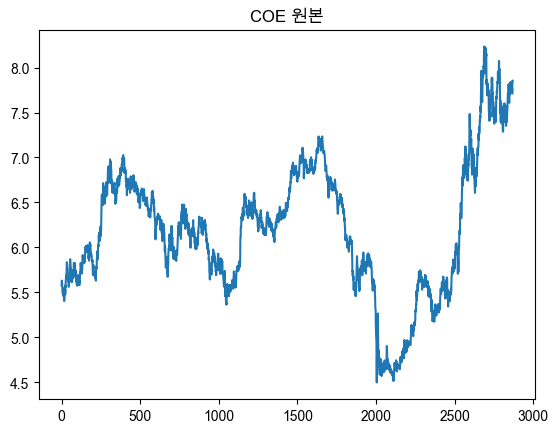

In [18]:
plt.plot(df['COE'])
plt.title("COE 원본")

Text(0.5, 1.0, '이동평균 적용 COE')

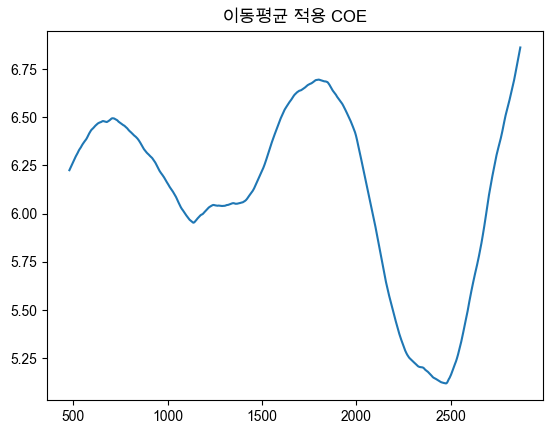

In [19]:
plt.plot(df['COE_MA2Y'])
plt.title("이동평균 적용 COE")

Text(0.5, 1.0, 'COE_MA1Y')

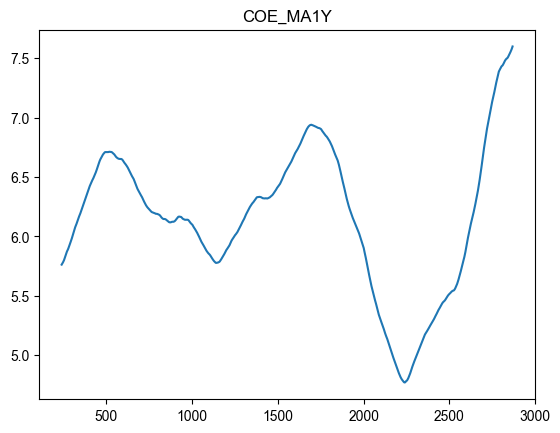

In [20]:
plt.plot(df['COE_MA1Y'])
plt.title("COE_MA1Y")

### ROE, Growth Multiplier 계산

- 순이익 = 영업이익 + 금융손익 + EMS *(1-20%)
- ROE = 순이익 / 총자본
- gm = PBR * COE / ROE

(1-20%): 법인세

In [21]:
# 년도와 분기를 포함한 컬럼 생성
df['YearQuarter'] = df['Date'].dt.to_period('Q')

In [22]:
#지수표현식 없애기
pd.options.display.float_format = '{:.5f}'.format


#되돌리기
pd.reset_option('display.float_format')

In [23]:
# 천원 단위 -> 원 단위
df['영업이익(원)'] = df['영업이익(천원)'] * 1000
df['금융손익(비영업)(원)'] = df['금융손익(비영업)(천원)'] * 1000
df['관계기업투자등관련손익(비영업)(원)'] = df['관계기업투자등관련손익(비영업)(천원)'] * 1000
df['총자본(원)'] = df['총자본(천원)'] * 1000

# 천원 단위 컬럼 삭제
df.drop(columns=['영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '총자본(천원)'], inplace=True)

In [24]:
df.head(3)

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원)
0,2012-07-02,5510,0.5607,1.580,NaN,NaN,2012Q3,5.580,NaN,NaN,2012Q3,-10336000000,-56562000000,173000000,3730074000000
1,2012-07-03,5570,0.56681,1.631,NaN,NaN,2012Q3,5.631,NaN,NaN,2012Q3,-10336000000,-56562000000,173000000,3730074000000
2,2012-07-04,5530,0.56274,1.631,NaN,NaN,2012Q3,5.631,NaN,NaN,2012Q3,-10336000000,-56562000000,173000000,3730074000000


In [25]:
df.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)'],
      dtype='object')

In [26]:
# YearQuarter 별로 가장 첫번째 값만 가져오는 코드
gr_yq_df = df.groupby('YearQuarter').agg({
    '영업이익(원)': 'first',
    '금융손익(비영업)(원)': 'first',
    '관계기업투자등관련손익(비영업)(원)': 'first',
    '총자본(원)': 'first'
})
'''
# 모든 컬럼을 정수형으로 변환
for column in gr_yq_df.columns:
    gr_yq_df[column] = gr_yq_df[column].astype(int)
    '''

'\n# 모든 컬럼을 정수형으로 변환\nfor column in gr_yq_df.columns:\n    gr_yq_df[column] = gr_yq_df[column].astype(int)\n    '

In [27]:
gr_yq_df

,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원)
YearQuarter,,,,
2012Q3,-10336000000,-56562000000,173000000,3730074000000
2012Q4,72084000000,-60772000000,-79000000,3748500000000
2013Q1,123153000000,-36864000000,301000000,3820191000000
2013Q2,144818000000,-49885000000,213000000,3907798000000
2013Q3,149210000000,-48767000000,216000000,3981683000000
2013Q4,124948000000,-61094000000,249000000,4022616000000
2014Q1,113185000000,-44736000000,442000000,3983603000000
2014Q2,98026000000,-69360000000,507000000,4013886000000
2014Q3,174509000000,-52236000000,89000000,4103313000000


In [28]:
# # 계단 평균의 이동평균을 계산하는 함수 정의
# def move_mean(data, window_size=4):
#     M = [None] * (window_size - 1)  # 첫 window_size - 1개는 NA로 채움
#     for n in range(len(data) - window_size + 1):
#         move_mean = sum(data[n:n+window_size]) / window_size
#         M.append(int(move_mean))  # 계산된 이동 평균을 정수형으로 변환
#     return M

# # 계단 평균의 이동평균을 계산하는 함수 정의
# def move_mean(data, window_size=4):
#     M = [None] * (window_size - 1)  # 첫 window_size - 1개는 NA로 채움
#     for n in range(len(data) - window_size + 1):
#         sum_cols = sum(data[n:n+window_size]) # 다 sum
#         M.append(int(sum_cols))  # 계산된 이동 평균을 정수형으로 변환
#     return M



In [29]:
def move_mean(data, data_type, window_size=4):
    M = [None] * (window_size - 1)  # 첫 window_size - 1개는 NA로 채움

    for n in range(len(data) - window_size + 1):
        window_data = data[n:n+window_size]

        if data_type in ["영업이익(원)", "금융손익(비영업)(원)", "관계기업투자등관련손익(비영업)(원)"]:
            sum_cols = sum(window_data)
            M.append(int(sum_cols))  # 계산된 합계를 정수형으로 변환
        elif data_type == "총자본(원)":
            avg_cols = sum(window_data) / window_size
            M.append(int(avg_cols))  # 계산된 평균을 정수형으로 변환
        else:
            M.append(None)  # 데이터 타입이 지정되지 않은 경우

    return M


In [30]:
# 각 컬럼에 대해 이동 평균을 계산
for column in ['영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)', '총자본(원)']:
    gr_yq_df[column + '_mean'] = move_mean(gr_yq_df[column], data_type=column)

gr_yq_df.tail(10)


,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean
YearQuarter,,,,,,,,
2021Q1,275617000000,-25232000000,422000000,7654154000000,9.420110e+11,-9.926900e+10,1.805000e+09,7.661567e+12
2021Q2,268420000000,-21510000000,431000000,7850809000000,9.707220e+11,-9.769400e+10,1.906000e+09,7.757103e+12
2021Q3,276739000000,-25298000000,545000000,7902636000000,9.962550e+11,-9.862800e+10,1.609000e+09,7.764703e+12
2021Q4,158238000000,-24575000000,914000000,7958558000000,9.790140e+11,-9.661500e+10,2.312000e+09,7.841539e+12
2022Q1,261246000000,-32221000000,910000000,7975956000000,9.646430e+11,-1.036040e+11,2.800000e+09,7.921990e+12
2022Q2,248374000000,-32549000000,489000000,8212179000000,9.445970e+11,-1.146430e+11,2.858000e+09,8.012332e+12
2022Q3,285067000000,-45993000000,1704000000,8313281000000,9.529250e+11,-1.353380e+11,4.017000e+09,8.114994e+12
2022Q4,286573000000,-55101000000,231000000,8449667000000,1.081260e+12,-1.658640e+11,3.334000e+09,8.237771e+12
2023Q1,260212000000,-57482000000,-396000000,8428711000000,1.080226e+12,-1.911250e+11,2.028000e+09,8.350960e+12


In [31]:
# # 각 컬럼에 대해 이동 평균을 계산
# for column in ['영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)', '총자본(원)']:
#     gr_yq_df[column + '_mean'] = move_mean(gr_yq_df[column])

# gr_yq_df.tail(10)

In [32]:
# 모든 컬럼을 정수형으로 변환
for column in gr_yq_df.columns:
    gr_yq_df[column] = pd.to_numeric(gr_yq_df[column], errors='coerce').astype('Int64')

In [33]:
gr_yq_df.columns

Index(['영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)', '총자본(원)',
       '영업이익(원)_mean', '금융손익(비영업)(원)_mean', '관계기업투자등관련손익(비영업)(원)_mean',
       '총자본(원)_mean'],
      dtype='object')

In [34]:
df_cleaned = pd.merge(df, gr_yq_df[['영업이익(원)_mean', '금융손익(비영업)(원)_mean', '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean']], on='YearQuarter')

In [35]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean'],
      dtype='object')

In [36]:
df_cleaned = df_cleaned.dropna()

In [37]:
df_cleaned['순이익'] = (df_cleaned['영업이익(원)_mean'] + df_cleaned['금융손익(비영업)(원)_mean'] + df_cleaned['관계기업투자등관련손익(비영업)(원)_mean']) * 0.8

In [38]:
df_cleaned.head(5)

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2014Q2,6.591,6.687496,6.225065,2014Q2,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0
482,2014-05-07,9870,1.0741,2.590,2.693433,2.231219,2014Q2,6.590,6.693433,6.231219,2014Q2,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2014Q2,6.602,6.695629,6.233312,2014Q2,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2014Q2,6.623,6.697554,6.235560,2014Q2,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2014Q2,6.656,6.699392,6.237942,2014Q2,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0


In [39]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean', '순이익'],
      dtype='object')

In [40]:
df_filtered = df_cleaned[df_cleaned['Date'] >= '2020-01-01']
df_filtered

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익
1958,2020-01-02,13850,0.85774,1.882,2.083292,2.504896,2020Q1,5.882,6.083292,6.504896,2020Q1,219757000000,-20506000000,-767000000,7319587000000,708889000000,-89302000000,79000000,7149347250000,495732800000.0
1959,2020-01-03,13800,0.85465,1.788,2.079529,2.502669,2020Q1,5.788,6.079529,6.502669,2020Q1,219757000000,-20506000000,-767000000,7319587000000,708889000000,-89302000000,79000000,7149347250000,495732800000.0
1960,2020-01-06,13600,0.84226,1.811,2.075725,2.500440,2020Q1,5.811,6.075725,6.500440,2020Q1,219757000000,-20506000000,-767000000,7319587000000,708889000000,-89302000000,79000000,7149347250000,495732800000.0
1961,2020-01-07,13800,0.85465,1.827,2.072079,2.498252,2020Q1,5.827,6.072079,6.498252,2020Q1,219757000000,-20506000000,-767000000,7319587000000,708889000000,-89302000000,79000000,7149347250000,495732800000.0
1962,2020-01-08,13450,0.83297,1.874,2.068629,2.496150,2020Q1,5.874,6.068629,6.496150,2020Q1,219757000000,-20506000000,-767000000,7319587000000,708889000000,-89302000000,79000000,7149347250000,495732800000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2023-06-26,11000,0.56781,3.719,3.580583,2.840927,2023Q2,7.719,7.580583,6.840927,2023Q2,288042000000,-52261000000,1045000000,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0
2866,2023-06-27,11090,0.57246,3.768,3.584671,2.846090,2023Q2,7.768,7.584671,6.846090,2023Q2,288042000000,-52261000000,1045000000,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0
2867,2023-06-28,11140,0.57504,3.710,3.588737,2.851023,2023Q2,7.710,7.588737,6.851023,2023Q2,288042000000,-52261000000,1045000000,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0
2868,2023-06-29,10690,0.55181,3.854,3.593625,2.856256,2023Q2,7.854,7.593625,6.856256,2023Q2,288042000000,-52261000000,1045000000,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0


In [41]:
df_cleaned['ROE'] = df_cleaned['순이익'] / df_cleaned['총자본(원)_mean']
df_cleaned['ROE'] = df_cleaned['ROE']*100

Text(0.5, 1.0, 'ROE(After)')

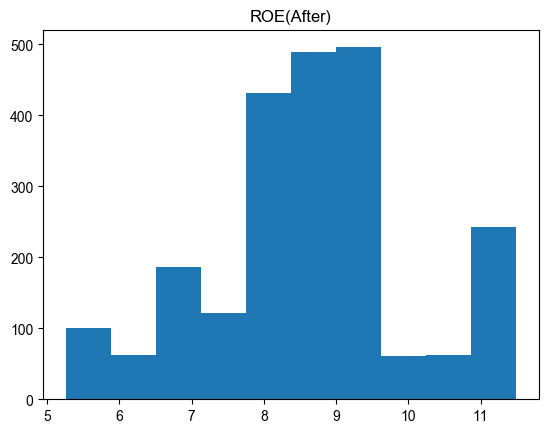

In [42]:
plt.hist(df_cleaned['ROE'])
plt.title('ROE(After)')

In [43]:
df_cleaned.head()

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,...,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익,ROE
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2014Q2,6.591,6.687496,6.225065,...,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933
482,2014-05-07,9870,1.0741,2.590,2.693433,2.231219,2014Q2,6.590,6.693433,6.231219,...,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2014Q2,6.602,6.695629,6.233312,...,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2014Q2,6.623,6.697554,6.235560,...,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2014Q2,6.656,6.699392,6.237942,...,98026000000,-69360000000,507000000,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933


In [44]:
df_cleaned['PBR(배)'] = pd.to_numeric(df_cleaned['PBR(배)'], errors='coerce')
df_cleaned['COE_MA2Y'] = pd.to_numeric(df_cleaned['COE_MA2Y'], errors='coerce')
df_cleaned['ROE'] = pd.to_numeric(df_cleaned['ROE'], errors='coerce')


In [45]:
df_cleaned['gm'] = df_cleaned['PBR(배)'] *  df_cleaned['COE_MA2Y'] /  df_cleaned['ROE']

In [46]:
# YearQuarter 별로 가장 첫번째 값만 가져오는 코드
df_cleaned_gr = df_cleaned.groupby('YearQuarter').agg({
    'ROE': 'first',
    'gm': 'first',
    'COE_MA2Y': 'first'
})

df_cleaned_gr

,ROE,gm,COE_MA2Y
YearQuarter,,,
2014Q2,5.255933,1.295354,6.225065
2014Q3,5.647021,1.10973,6.311035
2014Q4,6.726843,1.23714,6.420835
2015Q1,7.422476,1.053762,6.479225
2015Q2,9.495636,0.744575,6.492690
2015Q3,9.399599,0.666064,6.445265
2015Q4,8.242805,0.934244,6.378152
2016Q1,8.680567,0.725492,6.291073
2016Q2,8.639223,0.758417,6.190835


In [47]:
df=df_cleaned

In [48]:
# 년도와 분기를 추출하여 새로운 칼럼 추가하는 함수
def add_combined_year_quarter_column(df):
    # 'Date' 열을 datetime 형식으로 변환
    df['Date'] = pd.to_datetime(df['Date'])

    # 'Year' 칼럼 추가
    df['Year'] = df['Date'].dt.year.astype(str)

    # 'Quarter' 칼럼 추가
    df['Quarter'] = df['Date'].dt.quarter.astype(str)

    # 'Combined' 칼럼 추가 (년도와 분기 정보 통합)
    df['Combined'] = df['Year'] + df['Quarter']

add_combined_year_quarter_column(df)

# 결과 확인
df

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,...,총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익,ROE,gm,Year,Combined
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2,6.591,6.687496,6.225065,...,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.295354,2014,20142
482,2014-05-07,9870,1.07410,2.590,2.693433,2.231219,2,6.590,6.693433,6.231219,...,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.273409,2014,20142
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2,6.602,6.695629,6.233312,...,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.290618,2014,20142
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2,6.623,6.697554,6.235560,...,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.303992,2014,20142
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2,6.656,6.699392,6.237942,...,4013886000000,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.298033,2014,20142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2023-06-26,11000,0.56781,3.719,3.580583,2.840927,2,7.719,7.580583,6.840927,...,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.450495,2023,20232
2866,2023-06-27,11090,0.57246,3.768,3.584671,2.846090,2,7.768,7.584671,6.846090,...,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.454527,2023,20232
2867,2023-06-28,11140,0.57504,3.710,3.588737,2.851023,2,7.710,7.588737,6.851023,...,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.456904,2023,20232
2868,2023-06-29,10690,0.55181,3.854,3.593625,2.856256,2,7.854,7.593625,6.856256,...,8641735000000,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.438782,2023,20232


In [49]:
from sklearn.preprocessing import StandardScaler

# 데이터프레임에서 'gm' 열을 Combined별로 표준화하고, 'gm_s' 열을 추가하는 함수
def add_standardized_gm_column(df):
    # 'gm' 열을 표준화
    scaler = StandardScaler()
    df['gm_s'] = df.groupby('Combined')['gm'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# 함수 호출하여 'gm' 열을 Combined별로 표준화하고 'gm_s' 열 추가
add_standardized_gm_column(df)

# 결과 확인
df[['Date', 'Combined', 'gm', 'gm_s']]
df

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,...,영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익,ROE,gm,Year,Combined,gm_s
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2,6.591,6.687496,6.225065,...,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.295354,2014,20142,1.095844
482,2014-05-07,9870,1.07410,2.590,2.693433,2.231219,2,6.590,6.693433,6.231219,...,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.273409,2014,20142,0.562244
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2,6.602,6.695629,6.233312,...,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.290618,2014,20142,0.980700
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2,6.623,6.697554,6.235560,...,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.303992,2014,20142,1.305884
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2,6.656,6.699392,6.237942,...,485369000000,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.298033,2014,20142,1.161000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2023-06-26,11000,0.56781,3.719,3.580583,2.840927,2,7.719,7.580583,6.840927,...,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.450495,2023,20232,0.586888
2866,2023-06-27,11090,0.57246,3.768,3.584671,2.846090,2,7.768,7.584671,6.846090,...,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.454527,2023,20232,1.130080
2867,2023-06-28,11140,0.57504,3.710,3.588737,2.851023,2,7.710,7.588737,6.851023,...,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.456904,2023,20232,1.450376
2868,2023-06-29,10690,0.55181,3.854,3.593625,2.856256,2,7.854,7.593625,6.856256,...,1119894000000,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.438782,2023,20232,-0.991115


In [50]:
from sklearn.preprocessing import StandardScaler

# 데이터프레임에서 'gm' 열을 Combined별로 표준화하고, 'gm_s' 열을 추가하는 함수
def add_standardized_gm_column(df):
    # 'gm' 열을 표준화
    scaler = StandardScaler()
    df['PBR_s'] = df.groupby('Combined')['PBR(배)'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# 함수 호출하여 'gm' 열을 Combined별로 표준화하고 'gm_s' 열 추가
add_standardized_gm_column(df)

# 결과 확인
df[['Date', 'Combined', 'gm', 'gm_s']]
df

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,...,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익,ROE,gm,Year,Combined,gm_s,PBR_s
479,2014-05-02,10050,1.09369,2.591,2.687496,2.225065,2,6.591,6.687496,6.225065,...,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.295354,2014,20142,1.095844,1.194476
482,2014-05-07,9870,1.07410,2.590,2.693433,2.231219,2,6.590,6.693433,6.231219,...,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.273409,2014,20142,0.562244,0.680923
483,2014-05-08,10000,1.08825,2.602,2.695629,2.233312,2,6.602,6.695629,6.233312,...,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.290618,2014,20142,0.980700,1.051866
484,2014-05-09,10100,1.09913,2.623,2.697554,2.235560,2,6.623,6.697554,6.235560,...,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.303992,2014,20142,1.305884,1.337086
485,2014-05-12,10050,1.09369,2.656,2.699392,2.237942,2,6.656,6.699392,6.237942,...,-223957000000,1414000000,4000447000000,210260800000.0,5.255933,1.298033,2014,20142,1.161000,1.194476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2023-06-26,11000,0.56781,3.719,3.580583,2.840927,2,7.719,7.580583,6.840927,...,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.450495,2023,20232,0.586888,-0.708728
2866,2023-06-27,11090,0.57246,3.768,3.584671,2.846090,2,7.768,7.584671,6.846090,...,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.454527,2023,20232,1.130080,-0.163368
2867,2023-06-28,11140,0.57504,3.710,3.588737,2.851023,2,7.710,7.588737,6.851023,...,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.456904,2023,20232,1.450376,0.139219
2868,2023-06-29,10690,0.55181,3.854,3.593625,2.856256,2,7.854,7.593625,6.856256,...,-210837000000,2584000000,8458348500000,729312800000.0,8.622402,0.438782,2023,20232,-0.991115,-2.585235


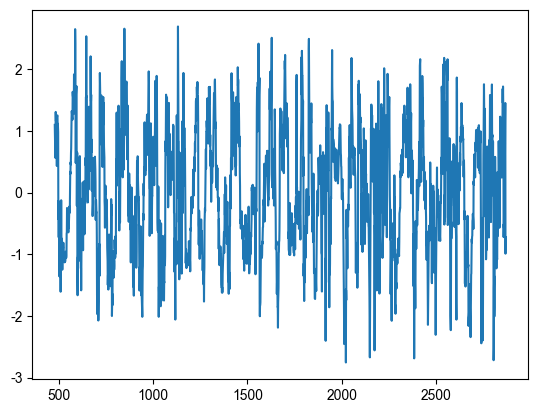

In [51]:
plt.plot(df['gm_s'])

In [52]:
df_cleaned.columns

Index(['Date', '종가(원)', 'PBR(배)', 'us_10_treasury', 'us_10_treasury_MA1Y',
       'us_10_treasury_MA2Y', 'Quarter', 'COE', 'COE_MA1Y', 'COE_MA2Y',
       'YearQuarter', '영업이익(원)', '금융손익(비영업)(원)', '관계기업투자등관련손익(비영업)(원)',
       '총자본(원)', '영업이익(원)_mean', '금융손익(비영업)(원)_mean',
       '관계기업투자등관련손익(비영업)(원)_mean', '총자본(원)_mean', '순이익', 'ROE', 'gm', 'Year',
       'Combined', 'gm_s', 'PBR_s'],
      dtype='object')

### 시점&수익률 생성

In [53]:
# # 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
# df['종가_1주후'] = df['종가(원)'].shift(-5) # 1주
# df['종가_2주후'] = df['종가(원)'].shift(-10) # 2주
# df['종가_1달후'] = df['종가(원)'].shift(-20) # 1달
# df['종가_3달후'] = df['종가(원)'].shift(-60) # 3달
# df['종가_6달후'] = df['종가(원)'].shift(-120) # 6달

In [54]:
# # for 문으로 6개월까지의 종가 생성
# for i in range(1, 181):
#     df[f'종가_{i}일후'] = df['종가(원)'].shift(-i)

### 일반 수익률

In [55]:
for i in range(1, 181):
    df[f'수익률_{i}일후'] = ((df['종가(원)'].shift(-i) - df['종가(원)']) / df['종가(원)'].shift(-i)) * 100

/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/2341591465.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'수익률_{i}일후'] = ((df['종가(원)'].shift(-i) - df['종가(원)']) / df['종가(원)'].shift(-i)) * 100
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/2341591465.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'수익률_{i}일후'] = ((df['종가(원)'].shift(-i) - df['종가(원)']) / df['종가(원)'].shift(-i)) * 100
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/2341591465.py:2: PerformanceWarning

In [56]:
# for i in range(1, 181):
#     df[f'수익률_{i}일후'] = df[f'종가_{i}일후'] - df['종가(원)'] / df['종가(원)'] * 100

In [57]:
# # 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
# df['수익률_1주후'] = (df['종가_1주후'] - df['종가(원)']) / df['종가(원)'] * 100
# df['수익률_2주후'] = (df['종가_2주후'] - df['종가(원)']) / df['종가(원)'] * 100
# df['수익률_1달후'] = (df['종가_1달후'] - df['종가(원)']) / df['종가(원)'] * 100
# df['수익률_3달후'] = (df['종가_3달후'] - df['종가(원)']) / df['종가(원)'] * 100
# df['수익률_6달후'] = (df['종가_6달후'] - df['종가(원)']) / df['종가(원)'] * 100

### 코스피(시장) 수익률 계산

In [58]:
# 코스피 지수 데이터 가져오기
df_kospi = yf.download('^KS11', start_dt, '2023-11-30')
df_kospi = df_kospi.reset_index() # index -> column
df = df.merge(df_kospi[['Date', 'Adj Close']]) # df에 df_kospi "Adj Close" 값 병합
df.rename(columns={'Adj Close': 'kospi'}, inplace=True) # 컬럼명 변경

[*********************100%%**********************]  1 of 1 completed


In [59]:
# # 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
# df['kospi_1주후'] = df['kospi'].shift(-5) # 1주
# df['kospi_2주후'] = df['kospi'].shift(-10) # 2주
# df['kospi_1달후'] = df['kospi'].shift(-20) # 1달
# df['kospi_3달후'] = df['kospi'].shift(-60) # 3달
# df['kospi_6달후'] = df['kospi'].shift(-120) # 6달

In [60]:
for i in range(1, 181):
    df[f'kospi_{i}일후'] = ((df['kospi'].shift(-i) - df['kospi']) / df['kospi'].shift(-i)) * 100

/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/486570113.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'kospi_{i}일후'] = ((df['kospi'].shift(-i) - df['kospi']) / df['kospi'].shift(-i)) * 100
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/486570113.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'kospi_{i}일후'] = ((df['kospi'].shift(-i) - df['kospi']) / df['kospi'].shift(-i)) * 100
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/486570113.py:2: PerformanceWarnin

In [61]:
# # 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
# df['kospi_수익률_1주후'] = (df['kospi_1주후'] - df['kospi']) / df['kospi'] * 100
# df['kospi_수익률_2주후'] = (df['kospi_2주후'] - df['kospi']) / df['kospi'] * 100
# df['kospi_수익률_1달후'] = (df['kospi_1달후'] - df['kospi']) / df['kospi'] * 100
# df['kospi_수익률_3달후'] = (df['kospi_3달후'] - df['kospi']) / df['kospi'] * 100
# df['kospi_수익률_6달후'] = (df['kospi_6달후'] - df['kospi']) / df['kospi'] * 100

In [62]:
# # 지수를 얼마나 이겼는지 (상대)수익률
# df['상대수익률_1주후'] = df['수익률_1주후'] - df['kospi_수익률_1주후']
# df['상대수익률_2주후'] = df['수익률_2주후'] - df['kospi_수익률_2주후']
# df['상대수익률_1달후'] = df['수익률_1달후'] - df['kospi_수익률_1달후']
# df['상대수익률_3달후'] = df['수익률_3달후'] - df['kospi_수익률_3달후']
# df['상대수익률_6달후'] = df['수익률_6달후'] - df['kospi_수익률_6달후']

In [63]:
for i in range(1, 181):
    df[f'상대수익률_{i}일후'] = df[f'수익률_{i}일후'] - df[f'kospi_{i}일후']

/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/1652349126.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'상대수익률_{i}일후'] = df[f'수익률_{i}일후'] - df[f'kospi_{i}일후']
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/1652349126.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'상대수익률_{i}일후'] = df[f'수익률_{i}일후'] - df[f'kospi_{i}일후']
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/1652349126.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [64]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 가정: df는 pandas DataFrame이며, 'gm'은 변환하고자 하는 열 이름입니다.
scaler = StandardScaler()

# df['gm']을 2차원 배열로 변환
gm_reshaped = df['gm'].values.reshape(-1, 1)

# 변환된 데이터를 표준화하고 결과를 다시 DataFrame에 저장
df['gm_ss'] = scaler.fit_transform(gm_reshaped)

/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_67583/3736745395.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['gm_ss'] = scaler.fit_transform(gm_reshaped)


In [65]:
import pandas as pd
import statsmodels.api as sm

In [66]:
best_r2 = -1
best_i = None

for i in range(1, 181):
    column_name = f'상대수익률_{i}일후'

    # 데이터 타입 변환 및 결측치 처리
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df['gm_s'] = pd.to_numeric(df['gm_s'], errors='coerce')
    df_temp = df[[column_name, 'gm_s']].dropna()

    # 선형 회귀 모델 적합
    X = df_temp[[column_name]]
    y = df_temp['gm_s']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # R2 값 계산
    r2 = model.rsquared

    if r2 > best_r2:
        best_r2 = r2
        best_i = i

print(f'가장 높은 R2 값을 가지는 상대수익률_{best_i}일후: {best_r2}')


가장 높은 R2 값을 가지는 상대수익률_33일후: 0.19256043138182555


In [67]:
import pandas as pd
import statsmodels.api as sm

# 가정: df는 이미 정의된 데이터프레임이며, 필요한 컬럼들을 포함하고 있음
best_r2 = -1
best_i = None
r2_values = {}

for i in range(1, 181):  # 또는 필요한 범위로 조정
    column_name = f'상대수익률_{i}일후'

    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df['gm_s'] = pd.to_numeric(df['gm_s'], errors='coerce')
    df_temp = df[[column_name, 'gm_s']].dropna()

    X = df_temp[[column_name]]
    y = df_temp['gm_s']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    r2 = model.rsquared
    r2_values[i] = r2  # R2 값 저장

    if r2 > best_r2:
        best_r2 = r2
        best_i = i

# 결과 출력
print(f'가장 높은 R2 값을 가지는 상대수익률_{best_i}일후: {best_r2}')

# 모든 R2 값 확인 (선택적)
print("각 상대수익률_{i}일후의 R2 값:")
for i, r2 in r2_values.items():
    print(f'상대수익률_{i}일후: {r2}')


가장 높은 R2 값을 가지는 상대수익률_33일후: 0.19256043138182555
각 상대수익률_{i}일후의 R2 값:
상대수익률_1일후: 0.03238074628727872
상대수익률_2일후: 0.05890652453709033
상대수익률_3일후: 0.0793857248605968
상대수익률_4일후: 0.09236280896154936
상대수익률_5일후: 0.10230445252835707
상대수익률_6일후: 0.10815979055935021
상대수익률_7일후: 0.1137989085419201
상대수익률_8일후: 0.11950709308027674
상대수익률_9일후: 0.1254527609409889
상대수익률_10일후: 0.1333786646905305
상대수익률_11일후: 0.142350764059074
상대수익률_12일후: 0.1485273545684157
상대수익률_13일후: 0.15566132269870048
상대수익률_14일후: 0.16191373116642704
상대수익률_15일후: 0.1661352161507107
상대수익률_16일후: 0.16809975049564196
상대수익률_17일후: 0.17049231144951948
상대수익률_18일후: 0.17096802232072894
상대수익률_19일후: 0.17388193972619959
상대수익률_20일후: 0.1740010093501665
상대수익률_21일후: 0.17609499631238235
상대수익률_22일후: 0.1791875543255177
상대수익률_23일후: 0.18119588324672198
상대수익률_24일후: 0.18461827900443484
상대수익률_25일후: 0.1861770098851151
상대수익률_26일후: 0.18762599438648608
상대수익률_27일후: 0.1893804301819556
상대수익률_28일후: 0.1896297211376049
상대수익률_29일후: 0.1888007406362855
상대수익률_30일후: 0.188168008944

In [68]:
import pandas as pd

# 가정: df는 이미 정의된 데이터프레임이며, 필요한 컬럼들을 포함하고 있음
lowest_corr = float('inf')
lowest_i = None

for i in range(1, 181):  # 또는 필요한 범위로 조정
    column_name = f'상대수익률_{i}일후'

    # 데이터 타입을 숫자형으로 변환하고 결측치 처리
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df['gm_s'] = pd.to_numeric(df['gm_s'], errors='coerce')
    df_temp = df[[column_name, 'gm_s']].dropna()

    # 상관관계 계산
    corr = df_temp[column_name].corr(df_temp['gm_s'])

    # 가장 낮은 상관관계 값 갱신
    if corr < lowest_corr:
        lowest_corr = corr
        lowest_i = i

# 결과 출력
print(f'상관관계가 가장 낮은 상대수익률_{lowest_i}일후: {lowest_corr}')


상관관계가 가장 낮은 상대수익률_33일후: -0.4388170819166283


Correlation coefficient: -0.44


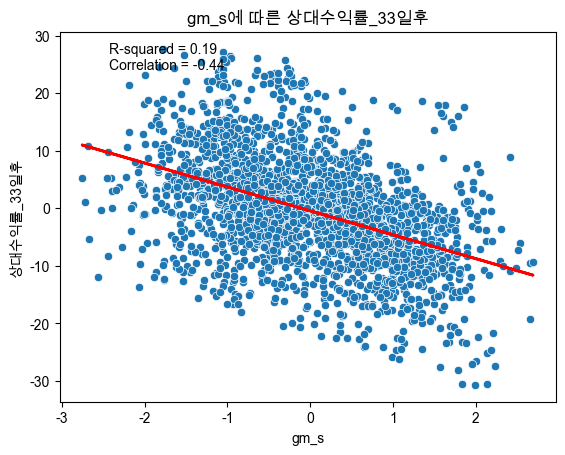

In [69]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

df_cleaned = df.dropna(subset=['gm_s', '상대수익률_33일후'])

correlation_coefficient, _ = pearsonr(df_cleaned['gm_s'], df_cleaned['상대수익률_33일후'])
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

sns.scatterplot(x='gm_s', y='상대수익률_33일후', data=df_cleaned)
X = df_cleaned[['gm_s']]
y = df_cleaned['상대수익률_33일후']
model = LinearRegression().fit(X, y)
plt.plot(df_cleaned['gm_s'], model.predict(X), color='red', linewidth=2)
r_squared = r2_score(y, model.predict(X))
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}\nCorrelation = {correlation_coefficient:.2f}', transform=plt.gca().transAxes)
plt.title('gm_s에 따른 상대수익률_33일후')
plt.xlabel('gm_s')
plt.ylabel('상대수익률_33일후')
plt.show()


In [70]:
print(df['gm_s'].min())
print(df['gm_s'].max())

-2.75436652498366
2.6905923982542888


In [71]:
import numpy as np

# 최대 평균 상대수익률을 저장할 변수와 해당 시점의 gm_s 값을 저장할 변수 초기화
max_mean_return = -np.inf
best_gm_s_value = None

# -2.7에서 2.6까지 0.1 단위로 gm_s의 값을 변경
for value in np.arange(-2.7, 2.7, 0.1):
    # 조건에 맞는 데이터프레임 생성
    df_gm_over_2 = df[df['gm_s'] < value]

    # 데이터가 없는 경우 건너뛰기
    if df_gm_over_2.shape[0] == 0:
        continue

    # 평균 상대수익률 계산
    mean_return = df_gm_over_2['상대수익률_33일후'].mean()

    # 현재 평균 상대수익률이 최대값인 경우 업데이트
    if mean_return > max_mean_return:
        max_mean_return = mean_return
        best_gm_s_value = value

# 결과 출력
print("최대 평균 상대수익률을 가진 gm_s의 값:", best_gm_s_value)
print("해당 gm_s 값에서의 평균 상대수익률:", max_mean_return)


최대 평균 상대수익률을 가진 gm_s의 값: -0.9999999999999987
해당 gm_s 값에서의 평균 상대수익률: 5.0071304741381395


In [72]:
df_gm_over_2 = df[df['gm_s'] < -1]
print(df_gm_over_2.shape[0])
df_gm_over_2['상대수익률_33일후'].mean()

397


5.0071304741381395

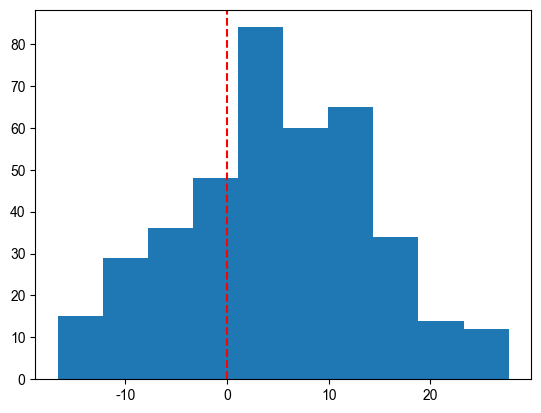

In [73]:
plt.hist(df_gm_over_2['상대수익률_33일후'])
plt.axvline(x=0, color='red', linestyle='--')

In [74]:
print(f"이긴 횟수: {(df_gm_over_2['상대수익률_33일후'] > 0).sum()}")
print(f"진 횟수: {(df_gm_over_2['상대수익률_33일후'] <= 0).sum()}")
print(f"평균수익률: {df_gm_over_2['상대수익률_33일후'].mean()}")
# print(f"최종 수익률: {(df_gm_over_2[df_gm_over_2['상대수익률_33일후'] > 0]['상대수익률_33일후'].sum()) - (df_gm_over_2[df_gm_over_2['상대수익률_33일후'] <= 0]['상대수익률_33일후'].sum())}")

이긴 횟수: 283
진 횟수: 114
평균수익률: 5.0071304741381395


In [75]:
from sklearn.linear_model import LinearRegression

# Drop rows with NaN values
df_cleaned = df.dropna(subset=['gm_s', '상대수익률_2주후'])

# 산점도 그리기
sns.scatterplot(x='gm_s', y='상대수익률_2주후', data=df_cleaned)

# 선형 회귀 모델 학습
X = df_cleaned[['gm_s']]
y = df_cleaned['상대수익률_2주후']
model = LinearRegression().fit(X, y)

# 회귀선 추가
plt.plot(df_cleaned['gm_s'], model.predict(X), color='red', linewidth=2)

# R-squared 값 계산
r_squared = r2_score(y, model.predict(X))

# 플롯에 R-squared 값 표시
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}', transform=plt.gca().transAxes)

# 그래프 꾸미기
plt.title('gm_s에 따른 상대수익률_2주후')
plt.xlabel('gm_s')
plt.ylabel('상대수익률_2주후')

# 그래프 출력
plt.show()

KeyError: ['상대수익률_2주후']

Correlation coefficient: -0.36


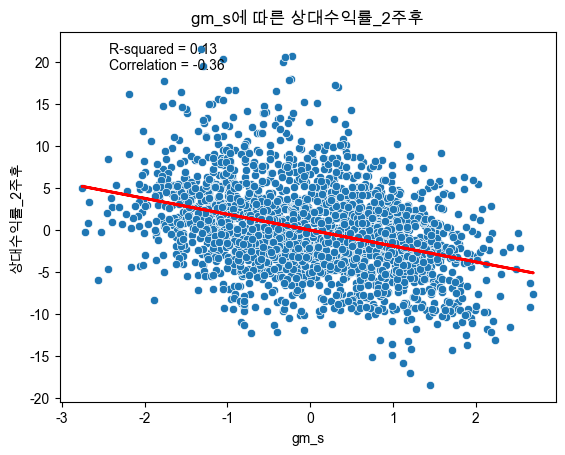

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

df_cleaned = df.dropna(subset=['gm_s', '상대수익률_2주후'])

correlation_coefficient, _ = pearsonr(df_cleaned['gm_s'], df_cleaned['상대수익률_2주후'])
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

sns.scatterplot(x='gm_s', y='상대수익률_2주후', data=df_cleaned)
X = df_cleaned[['gm_s']]
y = df_cleaned['상대수익률_2주후']
model = LinearRegression().fit(X, y)
plt.plot(df_cleaned['gm_s'], model.predict(X), color='red', linewidth=2)
r_squared = r2_score(y, model.predict(X))
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}\nCorrelation = {correlation_coefficient:.2f}', transform=plt.gca().transAxes)
plt.title('gm_s에 따른 상대수익률_2주후')
plt.xlabel('gm_s')
plt.ylabel('상대수익률_2주후')
plt.show()


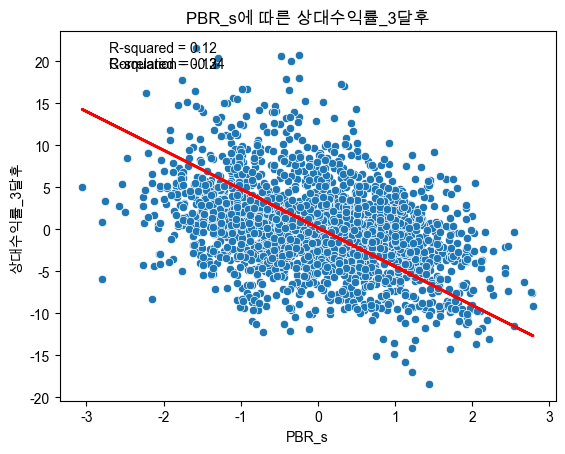

In [ ]:

# Drop rows with NaN values
df_cleaned = df.dropna(subset=['PBR_s', '상대수익률_3달후'])

# 산점도 그리기
sns.scatterplot(x='PBR_s', y='상대수익률_2주후', data=df_cleaned)

# 선형 회귀 모델 학습
X = df_cleaned[['PBR_s']]
y = df_cleaned['상대수익률_3달후']
model = LinearRegression().fit(X, y)

correlation_coefficient, _ = pearsonr(df_cleaned['PBR_s'], df_cleaned['상대수익률_3달후'])

# 회귀선 추가
plt.plot(df_cleaned['PBR_s'], model.predict(X), color='red', linewidth=2)

# R-squared 값 계산
r_squared = r2_score(y, model.predict(X))

# 플롯에 R-squared 값 표시
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}\nCorrelation = {correlation_coefficient:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}', transform=plt.gca().transAxes)

# 그래프 꾸미기
plt.title('PBR_s에 따른 상대수익률_3달후')
plt.xlabel('PBR_s')
plt.ylabel('상대수익률_3달후')

# 그래프 출력
plt.show()

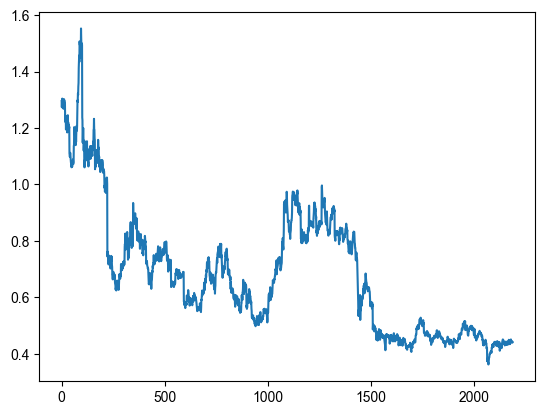

In [ ]:
plt.plot(df_cleaned['gm'])

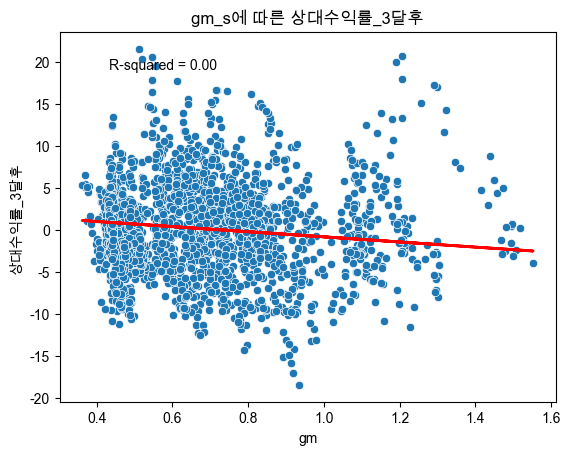

In [ ]:

# Drop rows with NaN values
df_cleaned = df.dropna(subset=['gm', '상대수익률_3달후'])

# 산점도 그리기
sns.scatterplot(x='gm', y='상대수익률_2주후', data=df_cleaned)

# 선형 회귀 모델 학습
X = df_cleaned[['gm']]
y = df_cleaned['상대수익률_3달후']
model = LinearRegression().fit(X, y)

# 회귀선 추가
plt.plot(df_cleaned['gm'], model.predict(X), color='red', linewidth=2)

# R-squared 값 계산
r_squared = r2_score(y, model.predict(X))

# 플롯에 R-squared 값 표시
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}', transform=plt.gca().transAxes)

# 그래프 꾸미기
plt.title('gm_s에 따른 상대수익률_3달후')
plt.xlabel('gm')
plt.ylabel('상대수익률_3달후')

# 그래프 출력
plt.show()

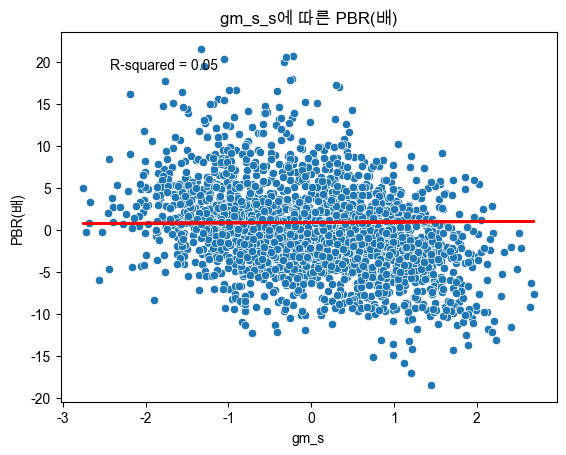

In [ ]:
# Drop rows with NaN values
df_cleaned = df.dropna(subset=['gm_s', 'PBR(배)'])

# 산점도 그리기
sns.scatterplot(x='gm_s', y='상대수익률_2주후', data=df_cleaned)

# 선형 회귀 모델 학습
X = df_cleaned[['gm_s']]
y = df_cleaned['PBR(배)']
model = LinearRegression().fit(X, y)

# 회귀선 추가
plt.plot(df_cleaned['gm_s'], model.predict(X), color='red', linewidth=2)

# R-squared 값 계산
r_squared = r2_score(y, model.predict(X))

# 플롯에 R-squared 값 표시
plt.text(0.1, 0.9, f'R-squared = {r_squared:.2f}', transform=plt.gca().transAxes)

# 그래프 꾸미기
plt.title('gm_s_s에 따른 PBR(배)')
plt.xlabel('gm_s')
plt.ylabel('PBR(배)')

# 그래프 출력
plt.show()

In [ ]:
df_cleaned.to_excel('coe_보기.xlsx')

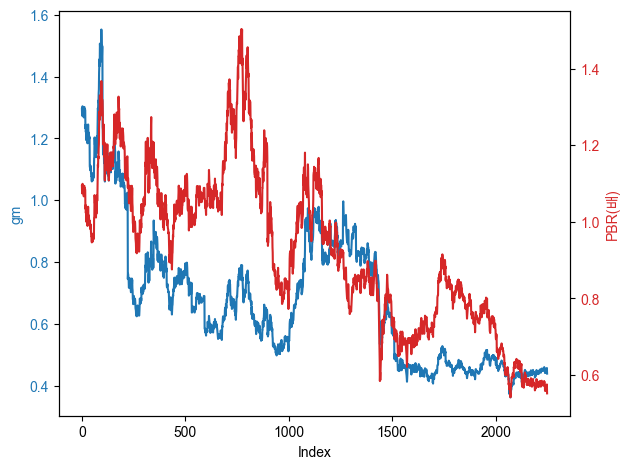

In [ ]:
#tmp_data = df_cleaned[df_cleaned['Combined'] == '20212']
tmp_data = df_cleaned
# Creating a plot with two y-axes using twinx
fig, ax1 = plt.subplots()

ax1.set_xlabel('Index')
ax1.set_ylabel('gm', color='tab:blue')
ax1.plot(tmp_data['gm'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PBR(배)', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(tmp_data['PBR(배)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

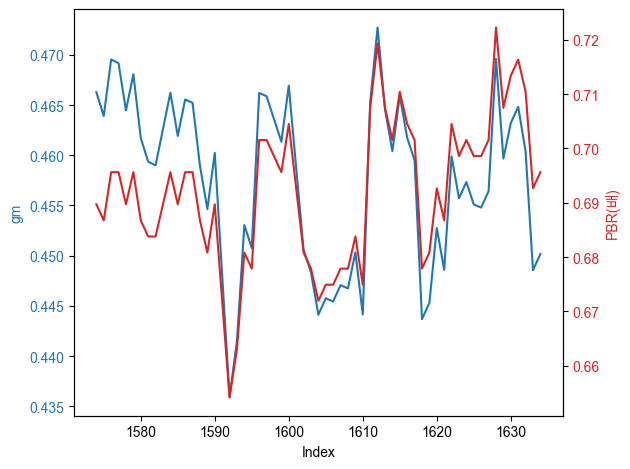

In [ ]:
tmp_data = df_cleaned[df_cleaned['Combined'] == '20204']
#tmp_data = df_cleaned
# Creating a plot with two y-axes using twinx
fig, ax1 = plt.subplots()

ax1.set_xlabel('Index')
ax1.set_ylabel('gm', color='tab:blue')
ax1.plot(tmp_data['gm'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PBR(배)', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(tmp_data['PBR(배)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

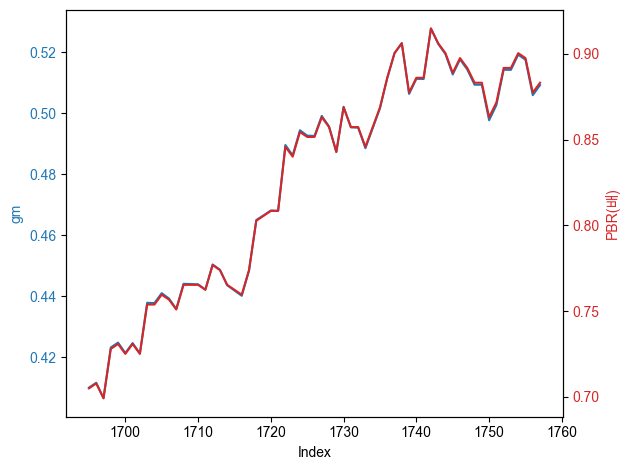

In [ ]:
tmp_data = df_cleaned[df_cleaned['Combined'] == '20212']
#tmp_data = df_cleaned
# Creating a plot with two y-axes using twinx
fig, ax1 = plt.subplots()

ax1.set_xlabel('Index')
ax1.set_ylabel('gm', color='tab:blue')
ax1.plot(tmp_data['gm'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PBR(배)', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(tmp_data['PBR(배)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

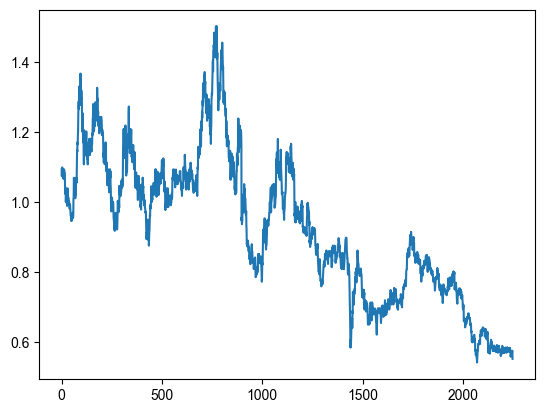

In [ ]:
plt.plot(df_cleaned['PBR(배)'])

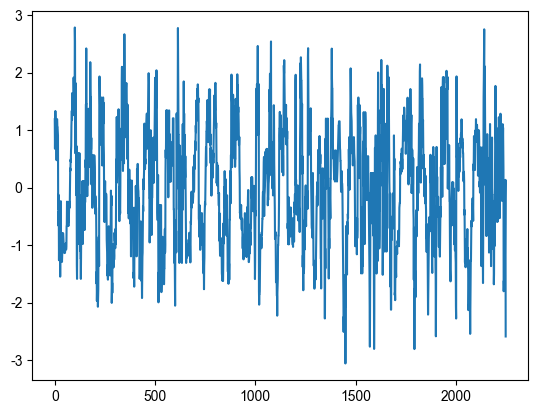

In [ ]:
plt.plot(df['PBR_s'])

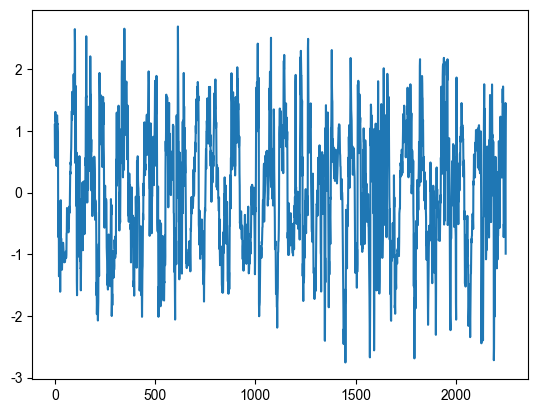

In [ ]:
plt.plot(df_cleaned['gm_s'])

In [ ]:
df_cleaned[df_cleaned['Year'] == '2022'].to_excel('tmp.xlsx')

In [ ]:
pd.set_option('display.max_columns', None)

tmp= df_cleaned[df_cleaned['Combined'] == '20224']
tmp

,Date,종가(원),PBR(배),us_10_treasury,us_10_treasury_MA1Y,us_10_treasury_MA2Y,Quarter,COE,COE_MA1Y,COE_MA2Y,YearQuarter,영업이익(원),금융손익(비영업)(원),관계기업투자등관련손익(비영업)(원),총자본(원),영업이익(원)_mean,금융손익(비영업)(원)_mean,관계기업투자등관련손익(비영업)(원)_mean,총자본(원)_mean,순이익,ROE,gm,Year,Combined,gm_s,PBR_s,종가_1주후,종가_2주후,종가_1달후,종가_3달후,종가_6달후,수익률_1주후,수익률_2주후,수익률_1달후,수익률_3달후,수익률_6달후,kospi,kospi_1주후,kospi_2주후,kospi_1달후,kospi_3달후,kospi_6달후,kospi_수익률_1주후,kospi_수익률_2주후,kospi_수익률_1달후,kospi_수익률_3달후,kospi_수익률_6달후,상대수익률_1주후,상대수익률_2주후,상대수익률_1달후,상대수익률_3달후,상대수익률_6달후
2065,2022-10-04,10650,0.56259,3.617,2.466292,1.922540,4,7.617,6.466292,5.922540,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.373449,2022,20224,-1.865645,-1.753350,10450,10900,11350,11350,10870,-1.877934,2.347418,6.57277,6.57277,2.065728,2209.379883,2202.469971,2237.439941,2336.870117,2280.449951,2434.939941,-0.312753,1.270042,5.770408,3.216743,10.209202,-1.565181,1.077376,0.802362,3.356027,-8.143474
2066,2022-10-05,10900,0.57580,3.759,2.475375,1.928396,4,7.759,6.475375,5.928396,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.382596,2022,20224,-1.482742,-1.261809,10250,11100,11250,11050,10920,-5.963303,1.834862,3.211009,1.376147,0.183486,2215.219971,2162.870117,2218.090088,2329.169922,2236.399902,2443.919922,-2.363190,0.129564,5.143956,0.956110,10.324029,-3.600113,1.705299,-1.932947,0.420037,-10.140543
2067,2022-10-06,10800,0.57052,3.826,2.484967,1.934450,4,7.826,6.484967,5.934450,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.379475,2022,20224,-1.613403,-1.458276,10450,11250,11750,10750,10800,-3.240741,4.166667,8.796296,-0.462963,0.0,2237.860107,2212.550049,2213.120117,2348.429932,2225.669922,2453.159912,-1.130994,-1.105520,4.940873,-0.544725,9.620789,-2.109747,5.272187,3.855423,0.081762,-9.620789
2068,2022-10-07,10700,0.56523,3.883,2.495092,1.940521,4,7.883,6.495092,5.940521,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.376341,2022,20224,-1.744598,-1.655116,10550,11200,11700,10900,10830,-1.401869,4.672897,9.345794,1.869159,1.214953,2232.840088,2219.709961,2236.159912,2371.790039,2218.679932,2476.860107,-0.588046,0.148682,6.223014,-0.634177,10.928683,-0.813823,4.524216,3.12278,2.503336,-9.71373
2069,2022-10-11,10500,0.55467,3.939,2.515500,1.952992,4,7.939,6.515500,5.952992,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.370085,2022,20224,-2.006477,-2.048052,10900,11250,11800,10900,10840,3.809524,7.142857,12.380952,3.809524,3.238095,2192.070068,2249.949951,2235.070068,2399.040039,2255.979980,2472.340088,2.640421,1.961616,9.441759,2.915505,12.785632,1.169103,5.181241,2.939193,0.894019,-9.547537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,2022-12-23,11800,0.62334,3.751,3.011350,2.258729,4,7.751,7.011350,6.258729,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.437263,2022,20224,0.805734,0.507146,10750,11100,11220,10960,10840,-8.898305,-5.932203,-4.915254,-7.118644,-8.135593,2313.689941,2225.669922,2350.189941,2428.570068,2424.479980,2582.629883,-3.804314,1.577567,4.965234,4.788457,11.623854,-5.093992,-7.50977,-9.880489,-11.907101,-19.759447
2123,2022-12-26,11800,0.62334,3.751,3.019750,2.263690,4,7.751,7.019750,6.263690,2022Q4,286573000000,-55101000000,231000000,8449667000000,1081260000000,-165864000000,3334000000,8237770750000,734984000000.0,8.922123,0.43761,2022,20224,0.820241,0.507146,10900,10850,11340,10960,10950,-7.627119,-8

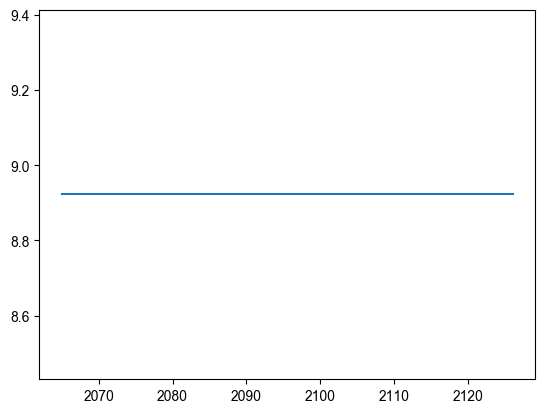

In [ ]:
plt.plot(tmp['ROE'])

~### 데이터 내보내기

In [ ]:
# # 저장할 폴더 경로 지정
# folder_path = '../gm_data'

# # 폴더가 없으면 생성
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # CSV 파일 저장
# df.to_csv(f'{folder_path}/{company}_df.csv', index=False)
